In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os,sys
MY_PATH = "MyEArecherche"
# #************************************
path_dir = os.path.join("/content/drive/My Drive", MY_PATH)
sys.path.append(os.path.join(path_dir, "Save"))
sys.path.append(path_dir)
%matplotlib inline
import numpy as np

import numpy.random as npr
import matplotlib.pyplot as plt

Mounted at /content/drive


## Simulation of the Ornstein-Uhlenbeck process

$$ dX_t = a(m - X_t) dt + \sigma \, dW_t, 
\qquad X_0 = x_0 \in \mathbb{R},
$$

where $a,m \in \mathbb{R}$, $\sigma > 0$, and $(W_t)_{t \ge 0}$ in a brownian motion in $\mathbb R$.

We consider a time horizon $T>0$ and a number of discretization steps $N\in{\mathbb N}^*$. 

We denote $t_k = T \frac k N$, $k \in \{0, \dots, N\}$.

For all $t \ge s$, $X$ verifies:
$$
X_t = e^{-a(t-s)} X_s + m(1 - e^{-a(t-s)})
+ \sigma e^{-a t} \int_s^t e^{a u} dW_u.
$$

where $\sigma e^{-a t} \int_s^t e^{a u} dW_u \sim \mathcal{N}(0,\dfrac{1-e^{-2a(t-s)}}{2a})$

This expression allows exact simulation of the Ornstein-Uhlenbeck process. For this simulation, we will set $m=0$, $\sigma=1$ and $X_0=0$. 

For the training data of our GAN, we will set $a=1$.

Once training is complete, we will sample Ornstein-Uhlenbeck processes with $a=2$ and check what the discriminator outputs on this data. If the discriminator outputs probabilities that are close to 0 on this data, it will mean that we successfully trained our GAN to be able to detect fake data.

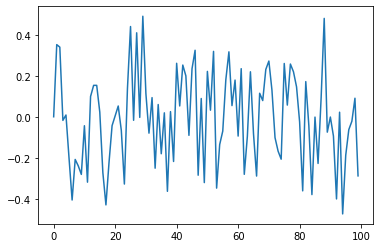

In [ ]:

def single_traj():

    n=100 # nbre de pas de temps
    T=100 # temps final
    time_step=T/n # pas de temps; 0.1 s
    grille_temps=np.arange(0,T,time_step) #longueur n

    a = 10
    sigma=1
    X=np.zeros(n)

    for i in range(1,n):
        X[i]=X[i-1]*np.exp(-a*time_step)+ sigma*npr.normal(0,np.sqrt((1-np.exp(-2*a*time_step))/2/a)) #évite numerical overflow de l'exponentielle pour la première méthode
        
    plt.plot(grille_temps, X)    
    plt.show()


def simul(N,train,save):
    n=100 # nbre de pas de temps
    T=100 # temps final
    time_step=T/n # pas de temps; 0.1 s
    sigma=1
    if train:
        a=4
    else:
        a=10
    X=np.zeros((N,n))
    grille_temps=np.arange(0,T,time_step) #longueur n

    for j in range(N):
        for i in range(1,n):
            X[j][i]=X[j][i-1]*np.exp(-a*time_step)+ sigma*npr.normal(0,np.sqrt((1-np.exp(-2*a*time_step))/2/a))

    if save:
        if train:
            plt.plot(grille_temps, X[0])    
            np.save(os.path.join(path_dir,'OUtrain.npy'),X)
        else:
            np.save(os.path.join(path_dir,'OUtest.npy'),X) #fake OU with different a that the discriminator must recognize
    if not(save):
        return X

def simul_all():
    Ntrain=20000 #nb de trajectoires du vent simulées pour le train
    Ntest=10 #nb de traj simulées pour le test
    simul(Ntrain,train=True,save=True)
    simul(Ntest,train=False,save=True)

n=100 # nbre de pas de temps
T=100 # temps final
time_step=T/n # pas de temps; 0.1 s

grille_temps=np.arange(0,T,time_step) #longueur n
single_traj()
#simul_all()
#Z = np.load(os.path.join(path_dir,'OUtrain.npy'))[0]
#print(Z.shape)
#plt.plot(grille_temps, Z)    
#plt.show()

## GAN MLP

In [3]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

n=100 # nbre de pas de temps
T=100 # temps final
time_step=T/n # pas de temps; 0.1 s

grille_temps=np.arange(0,T,time_step) #longueur n

class TSGAN():
    def __init__(self):
        # Input shape
        self.nb_time_steps = 100
        self.channels = 1
        self.img_shape = (self.nb_time_steps, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh')) #we can remove the ", activation='tanh'" that we used for images
        model.add(Reshape(self.img_shape))

        #model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, additional_epochs, batch_size=128, sample_interval=500,verbose=True,save=True,existing_epochs=0):

        # Load the dataset
        #X_train = np.load(os.path.join(path_dir, 'OUtrain.npy'))

        #X_train = np.expand_dims(X_train, axis=2) #shape(N=1000,384,1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        d_hist, g_hist = list(), list()

        for epoch in range(1,additional_epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            
            #idx = np.random.randint(0, X_train.shape[0], batch_size)
            #imgs = X_train[idx] #shape (batch_size, 384, 1)
            imgs= simul(batch_size,train=True,save=False)
            imgs = np.expand_dims(imgs, axis=2)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_hist.append(d_loss)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
            g_hist.append(g_loss)

            if epoch % sample_interval == 0:
                if save:
                    self.sample_images(epoch,existing_epochs)
                else:
                    self.sample_images(-1,existing_epochs)
            # Plot the progress
            if verbose:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        return np.array(d_hist),np.array(g_hist)

    def sample_images(self, epoch,existing_epochs): #if epoch = -1, does not save but show
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict(noise).flatten()
        fig, axs = plt.subplots()
        axs.plot(grille_temps,gen_imgs)
        if epoch!=-1:
            fig.savefig(os.path.join(path_dir,"Save/TSGAN/TSGAN{}.png".format(epoch+existing_epochs)))
        else:
            plt.show()
        plt.close()
        


gan = TSGAN()
existing_epochs=0
additional_epochs=3000
d_hist, g_hist=gan.train(additional_epochs=additional_epochs, batch_size=32,sample_interval=500,verbose=False,save=False,existing_epochs=existing_epochs) #d_hist: 1ere colonne perte, 2e colonne accuracy

Output on fake data (OU with different parameters):
[[0.8682238 ]
 [0.86317986]
 [0.8359756 ]
 [0.8336753 ]
 [0.87548923]
 [0.86965036]
 [0.72698265]
 [0.8011805 ]
 [0.8723111 ]
 [0.8167821 ]]
0.8363451

Output on real data (right parameters) not in train dataset:
[[0.851775  ]
 [0.64793664]
 [0.8402727 ]
 [0.78054094]
 [0.783261  ]
 [0.8613082 ]
 [0.9054759 ]
 [0.8389279 ]
 [0.7799073 ]
 [0.76848876]]
0.8057895

Output on real data (right parameters) in train dataset:
[[0.8075692 ]
 [0.7789283 ]
 [0.8427881 ]
 [0.75809884]
 [0.67136514]
 [0.77092814]
 [0.7236824 ]
 [0.8798248 ]
 [0.7267232 ]
 [0.7316025 ]]
0.7691511


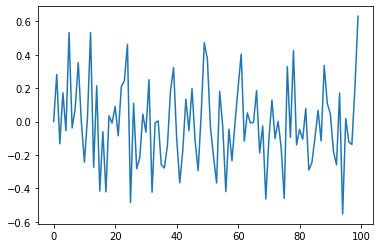

In [ ]:
def test():
    T=100
    n=100
    time_step=T/n
    grille_temps=np.arange(0,T,time_step) #longueur n
    sigma=1
    """
    fake data
    """
    X_test = np.load(os.path.join(path_dir, 'OUtest.npy')) #dim 10,gan.nb_time_steps
    X_test = np.expand_dims(X_test, axis=2) # dim : (10,gan.nb_time_steps, gan.channels)
    output = gan.discriminator.predict(X_test)
    print("Output on fake data (OU with different parameters):")
    print(output) 
    print(np.mean(output))
    print()

    """
    real data not in train dataset
    """
    N=10
    
    a=4
    X=np.zeros((N,n))
    

    for j in range(N):
        for i in range(1,n):
            X[j][i]=X[j][i-1]*np.exp(-a*time_step)+ sigma*npr.normal(0,np.sqrt((1-np.exp(-2*a*time_step))/2/a))

    output = gan.discriminator.predict(X)
    print("Output on real data (right parameters) not in train dataset:")
    print(output)
    print(np.mean(output))
    print()

    """
    real data in train dataset
    """
    X_train = np.load(os.path.join(path_dir, 'OUtrain.npy'))
    X_train = np.expand_dims(X_train, axis=2) #shape(N=20000,100,1)
    X_train = X_train[:10]
    output = gan.discriminator.predict(X_train)
    print("Output on real data (right parameters) in train dataset:")
    print(output)
    print(np.mean(output))

test()



The classical GAN-MLP does not work for fake data identification. Let us try with a Wasserstein GAN (MLP generator, Conv1D critic) instead.

## WGAN MLP/Conv1D

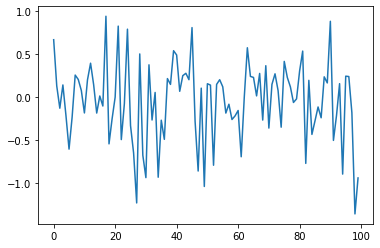

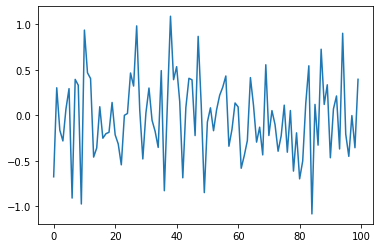

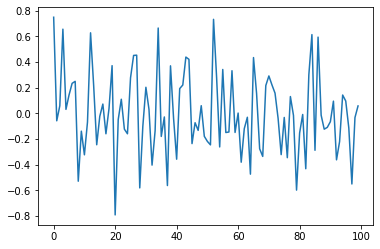

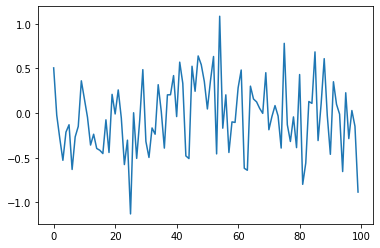

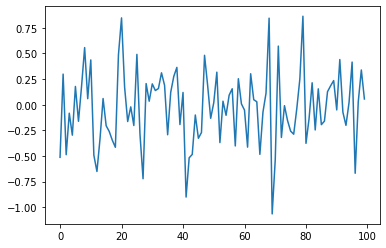

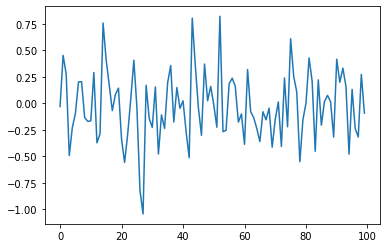

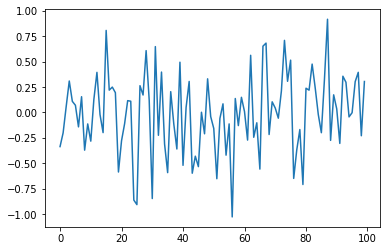

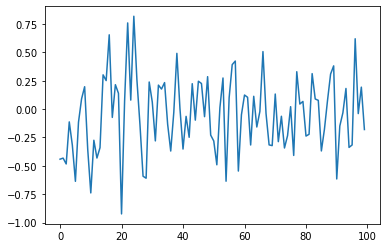

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.models import load_model

import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np

n=100 # nbre de pas de temps
T=100 # temps final
time_step=T/n # pas de temps; 0.1 s

grille_temps=np.arange(0,T,time_step) #longueur n


class TSGAN2():
    def __init__(self):

        self.nb_time_steps = 100
        self.channels = 1
        self.img_shape = (self.nb_time_steps, self.channels)
        self.latent_dim = 50 #instead of 100, because 38< 38x28


        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer) #original version: ,metrics=['accuracy'])
            

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer) #original version: ,metrics=['accuracy'])
 
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
   

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) #we remove , activation='tanh' (that was OK for images but not for time series)
        model.add(Reshape(self.img_shape))

        #model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)


    def build_critic(self):

        model = Sequential()

        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(self.nb_time_steps,self.channels)))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(Dropout(0.5))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dense(1))


        #model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, additional_epochs, batch_size=128, sample_interval=50,verbose=True,save=True,existing_epochs=0):
        #verbose= True => print loss at each step
        
        # Load the dataset
        X_train = np.load(os.path.join(path_dir, 'OUtrain.npy'))

        X_train = np.expand_dims(X_train, axis=2) #shape(N=5000,384,1)


        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        c_hist, g_hist = list(), list()

        for epoch in range(1,additional_epochs+1):

            for _ in range(self.n_critic):
                
                c_tmp = list()
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                c_loss_real = self.critic.train_on_batch(imgs, valid)
                c_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                c_loss = 0.5 * np.add(c_loss_fake, c_loss_real)
                c_tmp.append(c_loss*10**5)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            c_hist.append(np.mean(c_tmp))
            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)
            g_hist.append(g_loss*10**5)
            
            # Plot the progress
            if verbose:
                print ("%d [C loss: %f] [G loss: %f]" % (epoch, c_loss*10**5, g_loss*10**5)) #original version: 1 - c_loss[0], 1 - g_loss[0]

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                if not(save):
                    self.sample_images(-1,existing_epochs)
                else:
                    self.sample_images(epoch,existing_epochs)
                    if verbose:
                        self.sample_images(-1,existing_epochs)

        return np.array(c_hist),np.array(g_hist)

    def sample_images(self, epoch,existing_epochs): #if epoch = -1, does not save but show
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict(noise).flatten()
        fig, axs = plt.subplots()
        axs.plot(grille_temps,gen_imgs)
        if epoch!=-1:
            fig.savefig(os.path.join(path_dir,"Save/TSGAN/TSGAN{}.png".format(epoch+existing_epochs)))
        else:
            plt.show()
        plt.close()


gan = TSGAN2()
existing_epochs=0
additional_epochs=4000
c_hist, g_hist=gan.train(additional_epochs=additional_epochs, batch_size=32,sample_interval=500,verbose=False,save=False,existing_epochs=existing_epochs) 

In [ ]:
def test():
    """
    fake data
    """
    X_test = np.load(os.path.join(path_dir, 'OUtest.npy')) #dim 10,gan.nb_time_steps
    X_test = np.expand_dims(X_test, axis=2) # dim : (10,gan.nb_time_steps, gan.channels)
    output = gan.critic.predict(X_test)
    print("Output on fake data (OU with different parameters):")
    print(output) 
    print(np.mean(output))
    print()

    """
    real data not in train dataset
    """
    N=10
    n=100 # nbre de pas de temps
    T=100 # temps final
    time_step=T/n # pas de temps; 0.1 s
    sigma=1
    a=4
    X=np.zeros((N,n))
    grille_temps=np.arange(0,T,time_step) #longueur n

    for j in range(N):
        for i in range(1,n):
            X[j][i]=X[j][i-1]*np.exp(-a*time_step)+ sigma*npr.normal(0,np.sqrt((1-np.exp(-2*a*time_step))/2/a))

    output = gan.critic.predict(X)
    print("Output on real data (right parameters) not in train dataset:")
    print(output)
    print(np.mean(output))
    print()

    """
    real data in train dataset
    """
    X_train = np.load(os.path.join(path_dir, 'OUtrain.npy'))
    X_train = np.expand_dims(X_train, axis=2) #shape(N=1000,384,1)
    X_train = X_train[:10]
    output = gan.critic.predict(X_train)
    print("Output on real data (right parameters) in train dataset:")
    print(output)
    print(np.mean(output))

test()

Output on fake data (OU with different parameters):
[[0.0017112 ]
 [0.00157714]
 [0.00178789]
 [0.00181863]
 [0.00191427]
 [0.00218049]
 [0.00167797]
 [0.00158945]
 [0.00171654]
 [0.00166019]]
0.0017633768

Output on real data (right parameters) not in train dataset:
[[0.00397132]
 [0.00383269]
 [0.00345074]
 [0.00375788]
 [0.00476454]
 [0.00542349]
 [0.00359346]
 [0.00419627]
 [0.0039136 ]
 [0.00388771]]
0.0040791677

Output on real data (right parameters) in train dataset:
[[0.00450756]
 [0.00580779]
 [0.00327576]
 [0.0024514 ]
 [0.00547279]
 [0.00494548]
 [0.00467748]
 [0.00423671]
 [0.00329593]
 [0.00494324]]
0.0043614134


The WGAN successfully recognizes fake data. Let us try with other OU processes:

In [ ]:
def test_differents_OU():
    N=10
    n=100 # nbre de pas de temps
    T=100 # temps final
    time_step=T/n # pas de temps; 0.1 s
    """
    fake data a=10
    """
    sigma=1
    a=10
    X=np.zeros((N,n))
    grille_temps=np.arange(0,T,time_step) #longueur n

    for j in range(N):
        for i in range(1,n):
            X[j][i]=X[j][i-1]*np.exp(-a*time_step)+ sigma*npr.normal(0,np.sqrt((1-np.exp(-2*a*time_step))/2/a))

    output = gan.critic.predict(X)
    print("Output on fake data (a=10) not in train dataset:")
    print(output)
    print(np.mean(output))
    print()

    """
    fake data sigma=0.5
    """
    sigma=0.5
    a=4
    X=np.zeros((N,n))
    grille_temps=np.arange(0,T,time_step) #longueur n

    for j in range(N):
        for i in range(1,n):
            X[j][i]=X[j][i-1]*np.exp(-a*time_step)+ sigma*npr.normal(0,np.sqrt((1-np.exp(-2*a*time_step))/2/a))

    output = gan.critic.predict(X)
    print("Output on fake data (sigma=0.5) not in train dataset:")
    print(output)
    print(np.mean(output))
    print()

    """
    fake data x0=0.2
    """
    sigma=0.5
    a=4
    X=np.zeros((N,n))
    grille_temps=np.arange(0,T,time_step) #longueur n
    X[:,0]=0.2
    for j in range(N):
        for i in range(1,n):
            X[j][i]=X[j][i-1]*np.exp(-a*time_step)+ sigma*npr.normal(0,np.sqrt((1-np.exp(-2*a*time_step))/2/a))

    output = gan.critic.predict(X)
    print("Output on fake data (x0=0.2) not in train dataset:")
    print(output)
    print(np.mean(output))
    print()

    """
    real data not in train dataset
    """
    
    sigma=1
    a=4
    X=np.zeros((N,n))
    grille_temps=np.arange(0,T,time_step) #longueur n

    for j in range(N):
        for i in range(1,n):
            X[j][i]=X[j][i-1]*np.exp(-a*time_step)+ sigma*npr.normal(0,np.sqrt((1-np.exp(-2*a*time_step))/2/a))

    output = gan.critic.predict(X)
    print("Output on real data (right parameters) not in train dataset:")
    print(output)
    print(np.mean(output))
    print()

    """
    real data in train dataset
    """
    X_train = np.load(os.path.join(path_dir, 'OUtrain.npy'))
    X_train = np.expand_dims(X_train, axis=2) #shape(N=1000,384,1)
    X_train = X_train[:10]
    output = gan.critic.predict(X_train)
    print("Output on real data (right parameters) in train dataset:")
    print(output)
    print(np.mean(output))
test_differents_OU()

Output on fake data (a=10) not in train dataset:
[[0.00161817]
 [0.00158201]
 [0.00166234]
 [0.00158729]
 [0.00167434]
 [0.00175531]
 [0.00164038]
 [0.00203947]
 [0.0015838 ]
 [0.00163558]]
0.0016778682

Output on fake data (sigma=0.5) not in train dataset:
[[0.00158534]
 [0.0015913 ]
 [0.00158527]
 [0.00157894]
 [0.00159153]
 [0.00158434]
 [0.00158701]
 [0.00158601]
 [0.00170937]
 [0.00157646]]
0.0015975576

Output on fake data (x0=0.2) not in train dataset:
[[0.00173604]
 [0.00158145]
 [0.0015817 ]
 [0.00159057]
 [0.00158766]
 [0.00157876]
 [0.00165918]
 [0.0015777 ]
 [0.00158748]
 [0.00159211]]
0.0016072646

Output on real data (right parameters) not in train dataset:
[[0.00505396]
 [0.00485211]
 [0.00542212]
 [0.00338907]
 [0.00437836]
 [0.00434333]
 [0.00516698]
 [0.00336032]
 [0.00528822]
 [0.00369022]]
0.004494469

Output on real data (right parameters) in train dataset:
[[0.00450756]
 [0.00580779]
 [0.00327576]
 [0.0024514 ]
 [0.00547279]
 [0.00494548]
 [0.00467748]
 [0.0042367

Again, the detection is successful.